In [1]:
from instance import *
from evaluator import *

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

# 03/out

In [2]:
def display_grid_and_path(inst, evaluator, path):
    """
    Display a grid with nodes and path coverage visualization.
    
    Args:
        inst: AgcspInstance object containing grid_nodes and obstacle_nodes
        evaluator: AgcspEvaluator object to calculate coverage
        path: List of (row, col) tuples representing the path
    """
    covered_nodes = evaluator.get_covered_nodes_list(path)
    
    total_nodes = len(inst.grid_nodes)
    covered_count = len(covered_nodes)
    coverage_percentage = (covered_count / total_nodes) * 100 if total_nodes > 0 else 0
    
    # Check for obstacle coverage
    covered_obstacles = []
    obstacle_warning = ""
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        covered_set = set(map(tuple, covered_nodes))
        covered_obstacles = [obs for obs in inst.obstacle_nodes if tuple(obs) in covered_set]
        if covered_obstacles:
            obstacle_warning = f"{len(covered_obstacles)} obstacles covered!"
    
    plt.figure(figsize=(12, 10))
    
    # Plot valid nodes
    plt.scatter(inst.grid_nodes[:, 0], inst.grid_nodes[:, 1], c='#AAAAAA', s=3, 
               label='Uncovered Nodes', alpha=0.7)
    
    if len(covered_nodes) > 0:
        plt.scatter(covered_nodes[:, 0], covered_nodes[:, 1], c='#00AA44', s=4, 
                   label='Covered Nodes', alpha=0.8)
    
    # Plot obstacles
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        plt.scatter(inst.obstacle_nodes[:, 0], inst.obstacle_nodes[:, 1], c='#CC0000', s=4, 
                   marker='s', label='Obstacles', linewidths=0.5)
        
        # Highlight covered obstacles
        if covered_obstacles:
            covered_obstacles_arr = np.array(covered_obstacles)
            plt.scatter(covered_obstacles_arr[:, 1], covered_obstacles_arr[:, 0], 
                       c='#FF6600', s=10, marker='D', 
                       linewidths=2, label='Covered Obstacles')
    
    # Plot path
    path_arr = np.array(path)
    plt.plot(path_arr[:, 0], path_arr[:, 1], color='#9900CC', linewidth=3, 
             label='Sprayer Path', marker='o', markersize=6, markerfacecolor='white', 
             markeredgecolor='#9900CC', markeredgewidth=2)
    
    plt.axis('equal')
    plt.legend(loc='upper right', framealpha=0.9)
    
    title = f'Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%){obstacle_warning}'
    plt.title(title, fontsize=12, fontweight='bold')
    
    print(f"Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%)")
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        print(f"Obstacles: {len(covered_obstacles)}/{len(inst.obstacle_nodes)} covered")
        if covered_obstacles:
            print("WARNING: Sprayer is covering obstacles!")
    
    plt.show()

In [3]:
# Create a circular grid with inner obstacles
center_r, center_c = 100, 100
outer_radius = 80
inner_radius = 30
r_grid, c_grid = np.mgrid[0:200, 0:200]
dist_from_center = np.sqrt((r_grid - center_r)**2 + (c_grid - center_c)**2)
grid_nodes = np.argwhere(dist_from_center <= outer_radius)
obstacle_nodes = np.argwhere(dist_from_center <= inner_radius)

circular_inst = AgcspInstance(grid_nodes, obstacle_nodes, 15)
circular_evaluator = AgcspEvaluator(circular_inst)

Coverage: 5357/20081 nodes (26.7%)
Obstacles: 1122/2821 covered


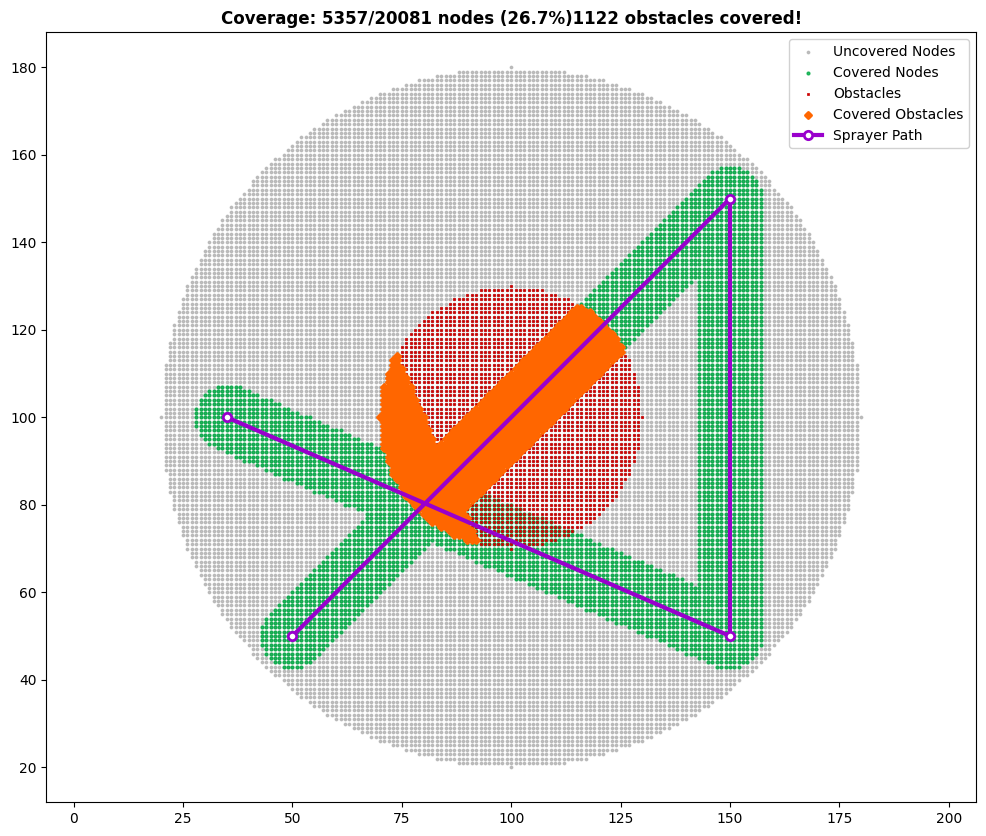

In [4]:
path=[(50, 50), (150, 150), (150, 50), (35, 100)]
display_grid_and_path(circular_inst, circular_evaluator, path)

In [5]:
sol = AgcspSolution(path)
display(circular_evaluator.coverage_proportion(sol))
display(sol.cache['hits_obstacle'])
circular_evaluator.manouver_complexity_penalty(sol)

np.float64(0.26676958318808824)

np.True_

np.float64(3.1058328926009975)

In [6]:
circular_evaluator.objfun(sol)

np.float64(370.6597815865669)

# Testing neighborhood step evaluations

### a) Node Removal Step

In [7]:
print("--- Teste do Movimento de Removal ---")

initial_sol_removal = AgcspSolution(path)
initial_cost_removal = circular_evaluator.objfun(initial_sol_removal)
print(f"Custo Inicial: {initial_cost_removal:.4f}")

node_idx_to_remove = 1
print(f"Ação: Remover o nó na posição {node_idx_to_remove}")

calculated_delta_removal = circular_evaluator.evaluate_removal_delta(initial_sol_removal, node_idx_to_remove)
print(f"Delta Calculado pelo método: {calculated_delta_removal:.4f}")

new_path_removal = np.delete(np.array(initial_sol_removal.path), node_idx_to_remove, axis=0)
new_sol_removal = AgcspSolution(new_path_removal)
new_cost_removal = circular_evaluator.objfun(new_sol_removal)
expected_delta_removal = new_cost_removal - initial_cost_removal

print(f"Custo da Nova Solução (recalculado): {new_cost_removal:.4f}")
print(f"Delta Esperado (new_cost - old_cost): {expected_delta_removal:.4f}")

if np.isclose(calculated_delta_removal, expected_delta_removal):
    print("\nO método 'evaluate_removal_delta' está correto.")
else:
    print("\nO delta calculado é diferente do esperado.")

--- Teste do Movimento de Removal ---
Custo Inicial: 370.6598
Ação: Remover o nó na posição 1
Delta Calculado pelo método: -142.5127
Custo da Nova Solução (recalculado): 228.1471
Delta Esperado (new_cost - old_cost): -142.5127

O método 'evaluate_removal_delta' está correto.


### b) Insertion Method

In [8]:
print("\n--- Teste do Movimento de Swap ---")

initial_sol_swap = AgcspSolution(path)
initial_cost_swap = circular_evaluator.objfun(initial_sol_swap)
print(f"Custo Inicial: {initial_cost_swap:.4f}")

idx1, idx2 = 1, 3
print(f"Ação: Trocar os nós nas posições {idx1} e {idx2}")

calculated_delta_swap = circular_evaluator.evaluate_swap_delta(initial_sol_swap, idx1, idx2)
print(f"Delta Calculado pelo método: {calculated_delta_swap:.4f}")

new_path_swap = np.array(initial_sol_swap.path).copy()
new_path_swap[idx1], new_path_swap[idx2] = new_path_swap[idx2].copy(), new_path_swap[idx1].copy()
new_sol_swap = AgcspSolution(new_path_swap)
new_cost_swap = circular_evaluator.objfun(new_sol_swap)
expected_delta_swap = new_cost_swap - initial_cost_swap

print(f"Custo da Nova Solução (recalculado): {new_cost_swap:.4f}")
print(f"Delta Esperado (new_cost - old_cost): {expected_delta_swap:.4f}")

if np.isclose(calculated_delta_swap, expected_delta_swap):
    print("\nO método 'evaluate_swap_delta' está correto.")
else:
    print("\nO delta calculado é diferente do esperado.")


--- Teste do Movimento de Swap ---
Custo Inicial: 370.6598
Ação: Trocar os nós nas posições 1 e 3
Delta Calculado pelo método: -89.2298
Custo da Nova Solução (recalculado): 281.4300
Delta Esperado (new_cost - old_cost): -89.2298

O método 'evaluate_swap_delta' está correto.


### c) Node swap step

In [9]:
print("\n--- Teste do Movimento de Swap ---")

initial_sol_swap = AgcspSolution(path)
initial_cost_swap = circular_evaluator.objfun(initial_sol_swap)
print(f"Custo Inicial: {initial_cost_swap:.4f}")

idx1, idx2 = 1, 3
print(f"Ação: Trocar os nós nas posições {idx1} e {idx2}")

calculated_delta_swap = circular_evaluator.evaluate_swap_delta(initial_sol_swap, idx1, idx2)
print(f"Delta Calculado pelo método: {calculated_delta_swap:.4f}")

new_path_swap = np.array(initial_sol_swap.path).copy()
new_path_swap[idx1], new_path_swap[idx2] = new_path_swap[idx2].copy(), new_path_swap[idx1].copy()
new_sol_swap = AgcspSolution(new_path_swap)
new_cost_swap = circular_evaluator.objfun(new_sol_swap)
expected_delta_swap = new_cost_swap - initial_cost_swap

print(f"Custo da Nova Solução (recalculado): {new_cost_swap:.4f}")
print(f"Delta Esperado (new_cost - old_cost): {expected_delta_swap:.4f}")

if np.isclose(calculated_delta_swap, expected_delta_swap):
    print("\nO método 'evaluate_swap_delta' está correto.")
else:
    print("\nO delta calculado é diferente do esperado.")


--- Teste do Movimento de Swap ---
Custo Inicial: 370.6598
Ação: Trocar os nós nas posições 1 e 3
Delta Calculado pelo método: -89.2298
Custo da Nova Solução (recalculado): 281.4300
Delta Esperado (new_cost - old_cost): -89.2298

O método 'evaluate_swap_delta' está correto.


### d) 2-Opt Method

In [10]:
print("\n--- Teste do Movimento de 2-Opt ---")

initial_sol_2opt = AgcspSolution(path)
initial_cost_2opt = circular_evaluator.objfun(initial_sol_2opt)
print(f"Custo Inicial: {initial_cost_2opt:.4f}")

i, j = 0, 2
print(f"Ação: Aplicar 2-Opt entre os nós {i} e {j}")

calculated_delta_2opt = circular_evaluator.evaluate_2opt_delta(initial_sol_2opt, i, j)
print(f"Delta Calculado pelo método: {calculated_delta_2opt:.4f}")

p = np.array(initial_sol_2opt.path)
new_path_2opt = np.concatenate([p[:i+1], p[j:i:-1], p[j+1:]])
new_sol_2opt = AgcspSolution(new_path_2opt)
new_cost_2opt = circular_evaluator.objfun(new_sol_2opt)
expected_delta_2opt = new_cost_2opt - initial_cost_2opt

print(f"Custo da Nova Solução (recalculado): {new_cost_2opt:.4f}")
print(f"Delta Esperado (new_cost - old_cost): {expected_delta_2opt:.4f}")

if np.isclose(calculated_delta_2opt, expected_delta_2opt):
    print("\nO método 'evaluate_2opt_delta' está correto.")
else:
    print("\nO delta calculado é diferente do esperado.")


--- Teste do Movimento de 2-Opt ---
Custo Inicial: 370.6598
Ação: Aplicar 2-Opt entre os nós 0 e 2
Delta Calculado pelo método: -42.1136
Custo da Nova Solução (recalculado): 328.5462
Delta Esperado (new_cost - old_cost): -42.1136

O método 'evaluate_2opt_delta' está correto.
